In [1]:
# UNCOMMENT first with internet option turned on
# Use GPU env

# !pip download tabpfn --no-deps -d pip-packages

# from tabpfn import TabPFNClassifier
# TabPFNClassifier(N_ensemble_configurations = 64, device = 'cuda:0')

# !mv /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt pip-packages/
# !zip -r pip-packages.zip pip-packages

# now you need to download the zip and upload it as dataset with the plus in the top left
# then you need to add it to the notebook as data on the right, and name it `pip-packages-icr`

# now you can turn internet off and still install, like below

In [2]:
# !pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages

In [3]:
# !mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
# !cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyprojroot import here

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer

from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from tabpfn import TabPFNClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

### Data Pull

In [135]:
# load data
local_dir = str(here()) + '/'
kaggle_dir = '/kaggle/input/'
train_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/test.csv')
greeks_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/greeks.csv')

# join greeks and add Epsilon
train_df = pd.merge(train_df, greeks_df, on = 'Id')
train_df = train_df.drop(['Id', 'Beta', 'Gamma', 'Delta'], axis = 1)
train_df['Epsilon'] = train_df['Epsilon'].replace('Unknown', np.nan)
train_df = train_df[train_df['Epsilon'].notna()]
train_df['Epsilon'] = pd.to_datetime(train_df['Epsilon'])

# change epsilon to days since 1-1-2019 when data started to pick up
train_df['Days Since 1-1-2019'] = (train_df['Epsilon'] - pd.to_datetime('2019-01-01')).dt.days
train_df = train_df.drop('Epsilon', axis = 1)
train_df.reset_index(drop = True, inplace = True)

In [136]:
# plot styles
font_dict_header = {'size': 20, 'weight': 'bold'}
font_dict_axistitle = {'size': 14, 'weight': 'bold'}

# Data Pre-Processing

In [137]:
# set random seed
random_seed = 101010
np.random.seed(random_seed)

# create x and y train
X_train = train_df.drop(['Alpha', 'Class'], axis = 1, inplace = False)
y_train_class = train_df['Class']
y_train_alpha = train_df['Alpha']
alpha_encoder = LabelEncoder()
y_train_alpha = alpha_encoder.fit_transform(y_train_alpha)

# clean categorical data
X_train['EJ'].replace({'A': 0, 'B': 1}, inplace = True)

# scale and impute data
X_train_columns = X_train.columns
X_train_index = X_train.index

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)

knn_imputer = KNNImputer()
X_train = knn_imputer.fit_transform(X_train)

X_train = pd.DataFrame(X_train, columns = X_train_columns, index = X_train_index)

# Alpha Prediction Features

### Model Prediction Features
KNN, Extra Trees, and TabPFN

In [138]:
def fit_model(model_name, model, X_train, y_train, X_test, features):
    X = X_train[features].copy()
    y = y_train.copy()
    test = X_test[features].copy()
    
    model.fit(X, y)
    model_predictions = model.predict_proba(test)
    predictions_df = pd.DataFrame(model_predictions, columns = model.classes_, index=X_test.index)
    predictions_df.columns = [model_name + '_' + str(col) for col in predictions_df.columns]
    
    return predictions_df

In [ ]:
# alpha models
knn = KNeighborsClassifier(n_neighbors = 7)
svm = SVC(probability = True, random_state = random_seed)
extra_trees = ExtraTreesClassifier(n_estimators = 250, random_state = random_seed)
tabpfn = TabPFNClassifier(N_ensemble_configurations = 64, seed = random_seed)

In [139]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
model_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_alpha)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_alpha[train_index], y_train_alpha[test_index]
    
    model_features = [
        'DU', 'CR', 'AB', 'DA', 'DH', 'BC', 'FR', 'EP', 'DI', 'FL', 'EU', 'EH', 'Days Since 1-1-2019'
    ]
    
    # fit models
    knn_features = model_features[0:3]
    knn_features.append(model_features[-1])
    
    knn_predictions = fit_model('KNN 7', knn, fold, fold_y, oof, knn_features)
    svm_predictions = fit_model('SVM', svm, fold, fold_y, oof, model_features)
    extra_trees_predictions = fit_model('Extra Trees', extra_trees, fold, fold_y, oof, model_features)
    tabpfn_predictions = fit_model('TabPFN', tabpfn, fold, fold_y, oof, model_features)
    
    predictions_df = pd.concat([knn_predictions, svm_predictions, extra_trees_predictions, tabpfn_predictions], axis = 1)
    model_prediction_features_df = pd.concat([model_prediction_features_df, predictions_df])
    
X_train = pd.concat([X_train, model_prediction_features_df], axis = 1)
for pred_class in y_train_alpha:
    X_train['Alpha_' + str(pred_class)] = X_train['Extra Trees_' + str(pred_class)] + X_train['TabPFN_' + str(pred_class)]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [122]:
pre_fit_models = {
    'KNN 7': knn.fit(X_train[knn_features], y_train_alpha),
    'Logistic Regression': log_reg.fit(X_train[log_reg_features], y_train_alpha),
    'SVM': svm.fit(X_train[model_features], y_train_alpha),
    'Extra Trees': extra_trees.fit(X_train[model_features], y_train_alpha)
}

In [123]:
print('Shape of X:', X_train.shape)
print('Shape of y:', y_train_alpha.shape)

Shape of X: (473, 77)
Shape of y: (473,)


In [124]:
# print('Shape of X:', X_test.shape)
# print('Shape of y:', y_test.shape)

# Model Pipeline

In [228]:
def competition_log_loss(y_true, y_pred):
    # calculate the predictin probability, clip it to avoid log(0) and calculate the log loss
    proba_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    proba_0 = np.clip(1 - proba_1, 1e-15, 1 - 1e-15)
    
    # count each class
    class_0 = np.sum(1 - y_true)
    class_1 = np.sum(y_true)

    # log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(proba_0)) / class_0
    log_loss_1 = -np.sum(y_true * np.log(proba_1)) / class_1
    
    # return average log loss
    return (log_loss_0 + log_loss_1)/2

# make scorer for sklearn GridSearchCV
balanced_log_loss_scorer = make_scorer(competition_log_loss, greater_is_better = False, needs_proba = True)

In [229]:
X_train['Class'] = y_train_class
X_train['Alpha'] = y_train_alpha

In [230]:
# models
xgb = XGBClassifier(
    booster = 'gbtree',
    learning_rate = 0.02,
    n_estimators = 300,
    max_depth = 6,
    gamma = 0.3,
    min_child_weight = 2,
    max_delta_step = 1,
    subsample = 0.7,
    base_score = 0.85,
    n_jobs = -1, random_state = random_seed
)

tabpfn = TabPFNClassifier(
    N_ensemble_configurations = 64
)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [247]:
y_true = []
y_pred = []
log_loss = []

skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_alpha)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y_class, oof_y_class = y_train_class[train_index], y_train_class[test_index]
    fold_y_alpha, oof_y_alpha = y_train_alpha[train_index], y_train_alpha[test_index]
    
    # over sample
    over_sampler = RandomOverSampler(random_state = random_seed)
    fold, fold_y_class = over_sampler.fit_resample(fold, fold_y_class)
    fold_y_alpha = fold['Alpha']
    fold.drop(['Alpha', 'Class'], axis = 1, inplace = True)
    oof.drop(['Alpha', 'Class'], axis = 1, inplace = True)
    
    # train models   
    xgb.fit(fold, fold_y_alpha)
    tabpfn.fit(fold[fold.columns[:-20]], fold_y_alpha)
    
    # predict oof
    oof_y_alpha_proba = xgb.predict_proba(oof)
    oof_y_alpha_proba += tabpfn.predict_proba(oof[oof.columns[:-20]])
    oof_y_alpha_proba /= 2
    
    # class_0 = oof_y_alpha_proba[:, 0].sum()
    # class_123 = oof_y_alpha_proba[:, 1:].sum()
    # new_probabilities = oof_y_alpha_proba * np.array([[1/(class_0 if i == 0 else class_123) for i in range(oof_y_alpha_proba.shape[1])]])
    # oof_y_alpha_proba =  new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
    
    oof_y_class_proba = oof_y_alpha_proba[:, 1:].sum(axis = 1)
    # oof_y_class_proba[oof_y_class_proba > 0.95] = 1
    # oof_y_class_proba[oof_y_class_proba < 0.025] = 0
    
    fold_log_loss = competition_log_loss(oof_y_class, oof_y_class_proba)
    log_loss.append(fold_log_loss)
    
    print('Balanced Log Loss:', fold_log_loss)
    y_true.append(oof_y_class)
    y_pred.append(oof_y_class_proba)

Balanced Log Loss: 0.18209156972660007
Balanced Log Loss: 0.3422173749443676
Balanced Log Loss: 0.16227826796703163
Balanced Log Loss: 0.37937077289688376
Balanced Log Loss: 0.18196387920742496


In [255]:
np.mean(log_loss)

0.2495843729484616

In [257]:
max_pred = [
    0.75, 0.76, 0.77, 0.78, 0.79, 
    0.80, 0.81, 0.82, 0.83, 0.84, 
    0.85, 0.86, 0.87, 0.88, 0.89, 
    0.90, 0.91, 0.92, 0.93, 0.94, 
    0.95, 0.96, 0.97, 0.98, 0.99,
    1.00
]
min_pred = [
    0.00, 0.01, 0.02, 0.03, 0.04, 
    0.05, 0.06, 0.07, 0.08, 0.09, 
    0.10, 0.11, 0.12, 0.13, 0.14, 
    0.15, 0.16, 0.17, 0.18, 0.19, 
    0.20, 0.21, 0.22, 0.23, 0.24, 
    0.25
]

optimal_thresholds = pd.DataFrame({}, columns = ['Max', 'Min', 'Log Loss'])
for max_v in max_pred:
    for min_v in min_pred:
        for i in range(len(y_pred)):
            fold_pred = y_pred[i].copy()
            fold_true = y_true[i].copy()
            
            fold_pred[fold_pred > max_v] = 1
            fold_pred[fold_pred < min_v] = 0
            
            loss = competition_log_loss(fold_true, fold_pred)
            
            # add to dataframe
            new_row = pd.DataFrame({'Max': [max_v], 'Min': [min_v], 'Log Loss': [loss]})
            optimal_thresholds = pd.concat([optimal_thresholds, new_row], ignore_index = True)

In [260]:
optimal_thresholds.groupby(['Max', 'Min']).mean().sort_values('Log Loss', ascending = True).head(10)

,,Log Loss
Max,Min,
0.82,0.0,0.229808
0.83,0.0,0.231609
0.84,0.0,0.234067
0.85,0.0,0.234823
0.86,0.0,0.235584
0.87,0.0,0.237498
0.88,0.0,0.238735
0.89,0.0,0.239875
0.90,0.0,0.240897


In [242]:
optimal_thresholds[optimal_thresholds['Max'] == 0.95]

,Max,Min,Log Loss
2500,0.95,0.01,0.900004
2501,0.95,0.01,2.392795
2502,0.95,0.01,0.812692
2503,0.95,0.01,2.585595
2504,0.95,0.01,1.147512
...,...,...,...
2620,0.95,0.25,0.900004
2621,0.95,0.25,2.392795
2622,0.95,0.25,0.812692
2623,0.95,0.25,2.585595


In [224]:
proba_1 = np.clip(y_pred[4], 1e-15, 1 - 1e-15)
proba_0 = np.clip(1 - proba_1, 1e-15, 1 - 1e-15)

class_0 = np.sum(1 - y_true[4])
class_1 = np.sum(y_true[4])

In [225]:
np.log(1e-15)

-34.538776394910684

In [226]:
proba_0

array([1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e-15,
       1.0000000e+00, 1.0000000e+00, 5.7185173e-01, 1.0000000e+00,
       1.0000000e+00, 1.0000000e-15, 1.0000000e-15, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e-15, 2.7839404e-01, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 2.7739519e-01, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 6.7139268e-01,
       1.0000000e+00, 1.0000000e-15, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 3.8805455e-01,
       1.0000000e+00, 1.0000000e-15, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 4.8171961e-01, 1.0000000e+00,
       1.0000000e+00, 4.7657430e-01, 1.0000000e+00, 2.6739550e

In [227]:
np.log(proba_0)

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        , -34.538776  ,
         0.        ,   0.        ,  -0.55887556,   0.        ,
         0.        , -34.538776  , -34.538776  ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       -34.538776  ,  -1.2787178 ,   0.        ,   0.        ,
         0.        ,  -1.2823122 ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  -0.39840108,
         0.        , -34.538776  ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  -0.9466094 ,
         0.        , -34.538776  ,   0.        ,   0.        ,
         0.        ,   0.        ,  -0.73039305,   0.        ,
         0.        ,  -0.74113166,   0.        ,  -1.3190265 ,
       -34.538776  ,   0.        , -34.538776  ,   0.  

In [ ]:
# calculate the predictin probability, clip it to avoid log(0) and calculate the log loss
proba_1 = np.clip(y_pred[4], 1e-15, 1 - 1e-15)
proba_0 = 1 - proba_1

# count each class
class_0 = np.sum(1 - y_true)
class_1 = np.sum(y_true)

# log loss for each class
log_loss_0 = -np.sum((1 - y_true) * np.log(proba_0)) / class_0
log_loss_1 = -np.sum(y_true * np.log(proba_1)) / class_1

# return average log loss
return (log_loss_0 + log_loss_1)/2

# make scorer for sklearn GridSearchCV
balanced_log_loss_scorer = make_scorer(competition_log_loss, greater_is_better = False, needs_proba = True)

In [179]:
y_true[0]

class_0 = np.sum(1 - y_true[4])
class_0

73

In [132]:
feature_cols = X_train.columns
feature_cols = feature_cols.drop(['Class', 'Alpha'])

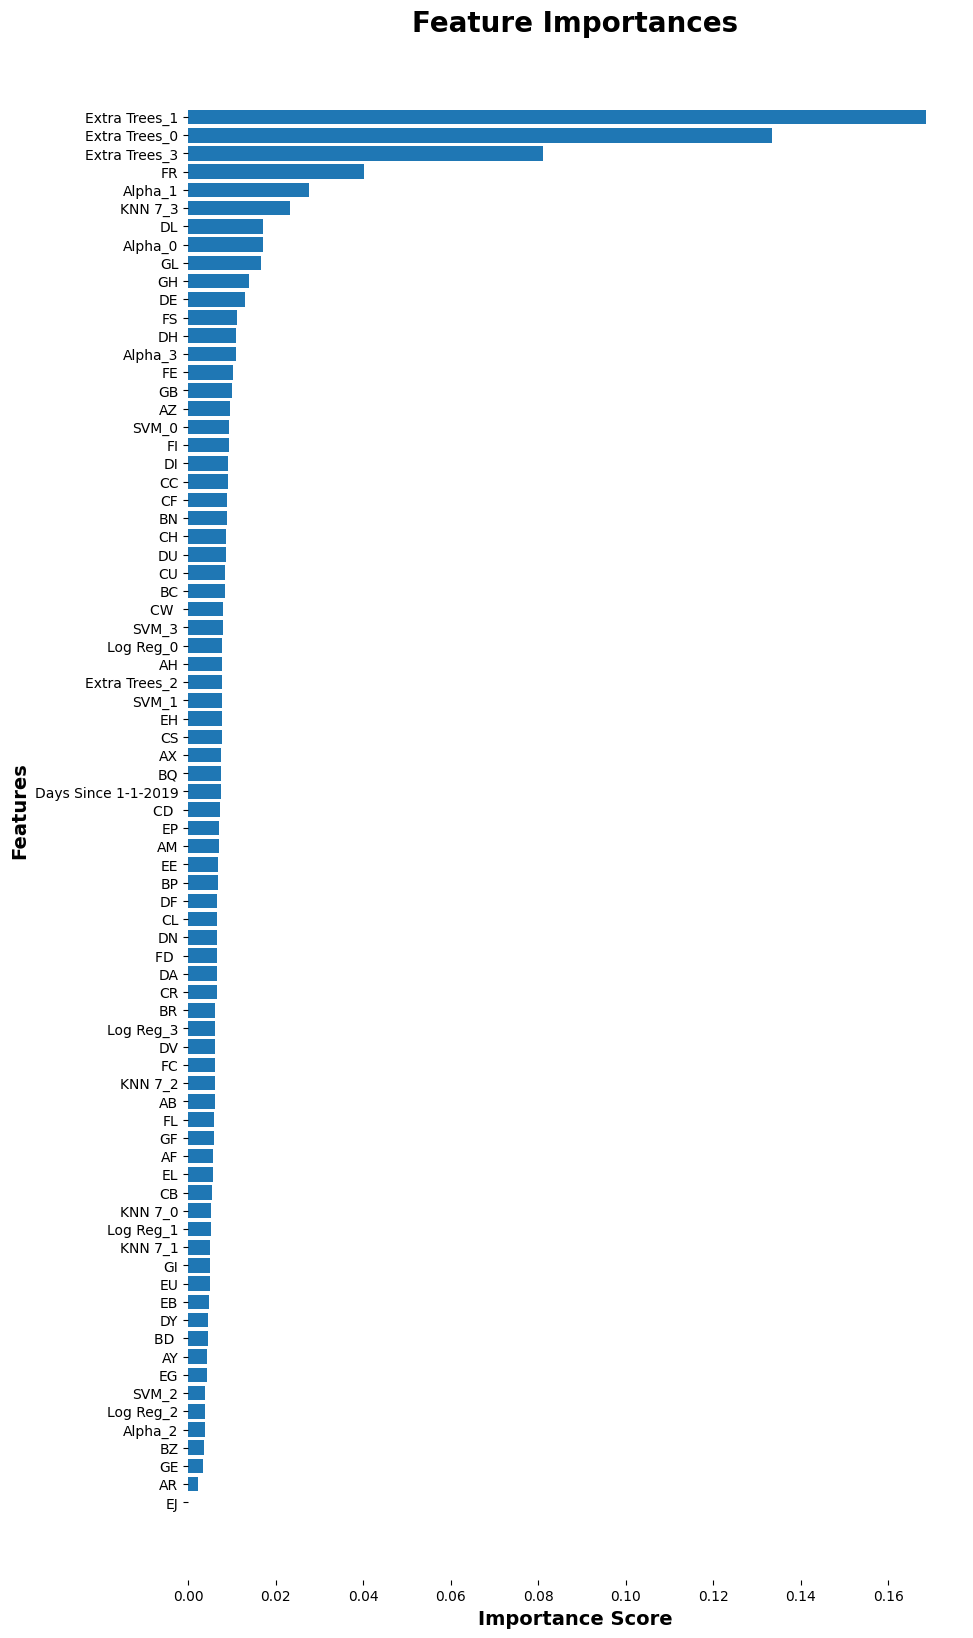

In [133]:
importances = pd.Series(xgb.feature_importances_, index = feature_cols).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()